In [103]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd
from scipy.linalg import eigh

In [104]:
# Load the data
def load_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            # Skip comment and description lines
            if line.startswith('%') or line.strip() == '' or 'X Height' in line:
                continue
            parts = line.split()
            if len(parts) == 2:
                try:
                    k = float(parts[0])
                    freq = float(parts[1])
                    data.append((k, freq))
                except ValueError:
                    continue
    return np.array(data)

In [105]:
def hamiltonian(k, gamma_0, phi):
    """
    Constructs the monolayer Hamiltonian matrix for a given k value.

    Parameters:
    k : float - parameter k that parameterizes the irreducible Brillouin zone
    gamma_0, phi : float - fit parameter

    Returns:
    4x4 Hamiltonian matrix
    """
    omega_0 = 3.976588
    gamma_1 = 0.007588

    # Calculate alpha and beta as functions of k
    if 0 <= k <= 1:
        alpha = 2/3 * k
        beta = 1/3 * k
    elif 1 <= k <= 2:
        alpha = 1/6 * (5 - k)
        beta = 1/6 * (k + 1)
    elif 2 <= k <= 3:
        alpha = 1/2 * (3 - k)
        beta = 1/2 * (3 - k)
    else:
        raise ValueError("k value out of range [0, 3]")

    # Calculate kx and ky
    k0 = 4 * np.pi / (3 * 15.0)
    kx = alpha * k0 * np.sqrt(3) / 2
    ky = k0 * (beta - alpha / 2)

    # Calculate f(k)
    f_k = np.exp(1j * ky * 15.0) + 2 * np.exp(-1j * ky * 15.0 / 2) * np.cos(kx * 15.0 * np.sqrt(3) / 2)

    # Hamiltonian matrix
    H = np.array([
        [omega_0, -gamma_0 * f_k, gamma_1*np.exp(1j*phi), 0],
        [-gamma_0*np.conj(f_k), omega_0, 0, gamma_1*np.exp(-1j*phi)],
        [gamma_1*np.exp(-1j*phi), 0, omega_0, -gamma_0*f_k],
        [0, gamma_1*np.exp(1j*phi), -gamma_0*np.conj(f_k), omega_0]
    ])

    return H

In [106]:
def calculate_eigenvalues(k, gamma_0, phi):
    """
    Calculates eigenvalues of the Hamiltonian for a given k value.

    Parameters:
    k : float - parameter k
    gamma_0, phi : float - H parameters

    Returns:
    Array of eigenvalues (frequencies)
    """
    H = hamiltonian(k, gamma_0, phi)
    eigenvalues, _ = eigh(H)
    return np.real(eigenvalues)  # Ensure eigenvalues are real

In [107]:
# Define the cost function for optimization
def cost_function(params, k_values, measured_freq, num_bands=4):
    """
    Cost function to minimize: root-mean-square deviation between
    calculated and measured frequencies.

    Parameters:
    params : array-like - [gamma_0, phi]
    k_values : array-like - k parameter values
    measured_freq : array-like - measured frequencies
    num_bands : int - number of bands

    Returns:
    float - RMSD
    """
    gamma_0, phi = params

    # Reshape measured frequencies to separate bands
    measured_reshaped = measured_freq.reshape(-1, num_bands)

    # Calculate model frequencies
    calculated_freq = np.array([calculate_eigenvalues(k, gamma_0, phi) for k in k_values])

    # Sort frequencies to ensure proper comparison
    calculated_freq.sort(axis=1)
    measured_reshaped.sort(axis=1)

    # Calculate RMSD
    diff = calculated_freq - measured_reshaped
    rmsd = np.sqrt(np.mean(diff**2))

    return rmsd

In [108]:
# Main function to fit data and generate output
def fit_hamiltonian(data_path, output_path):
    # Load data
    data = load_data(data_path)

    # Process data to get unique k values and corresponding frequencies
    unique_k = np.unique(data[:, 0])
    freq_matrix = np.zeros((len(unique_k), 4))

    for i, k in enumerate(unique_k):
        freqs = data[data[:, 0] == k, 1]
        freq_matrix[i, :len(freqs)] = freqs[:4]  # Taking first four frequencies

    # Initial guess for parameters
    initial_params = [0.1, 0.1]  # Initial guess for gamma_3 and gamma_4

    # Optimize parameters
    result = minimize(
        cost_function,
        initial_params,
        args=(unique_k, freq_matrix, 4),
        method='Nelder-Mead'
    )

    gamma_0_opt, phi_opt = result.x
    print(f"Optimal parameters: gamma_0 = {gamma_0_opt} phi = {phi_opt}")
    print(f"Final RMSD: {result.fun}")

    # Generate fitted data for a fine k grid
    k_fine = np.linspace(np.min(unique_k), np.max(unique_k), 100)
    fitted_freq = np.array([calculate_eigenvalues(k, gamma_0_opt, phi_opt) for k in k_fine])

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.scatter(data[:, 0], data[:, 1], label='COMSOL Data')
    plt.plot(k_fine, fitted_freq[:, 0], 'r-', label='Band 1')
    plt.plot(k_fine, fitted_freq[:, 1], 'r-', label='Band 2')
    plt.plot(k_fine, fitted_freq[:, 2], 'r-', label='Band 3')
    plt.plot(k_fine, fitted_freq[:, 3], 'r-', label='Band 4')
    plt.xlabel('k Parameter')
    plt.ylim(3.95, 4)
    plt.ylabel('Frequency (GHz)')
    plt.title('Monolayer Graphene Hamiltonian Fitting')
    plt.legend()
    plt.grid(True)

    # Save fitted data to output file
    with open(output_file, 'w') as f:
        f.write("% Fitted data for AB Stack Bilayer Graphene\n")
        f.write(f"% Parameters: gamma_0 = {gamma_0_opt:.6f} phi = {phi_opt:.6f}\n")
        f.write(f"% RMSD = {result.fun:.8f}\n")
        f.write("% k Band1 Band2 Band3 Band4\n")

        # Save all k_fine values and corresponding eigenvalues
        for i, k in enumerate(k_fine):
            f.write(f"{k:.6f} {fitted_freq[i, 0]:.6f} {fitted_freq[i, 1]:.6f} {fitted_freq[i, 2]:.6f} {fitted_freq[i, 3]:.6f}\n")

    return gamma_0_opt, phi_opt, k_fine, fitted_freq

In [109]:
# Save COMSOL data to a proper text file
def save_comsol_data(data_text, output_file):
    with open(output_file, 'w') as f:
        f.write(data_text)
    return output_file

Optimal parameters: gamma_0 = 0.052368471827066776 phi = 0.5379902584438989
Final RMSD: 0.0013240802307714899


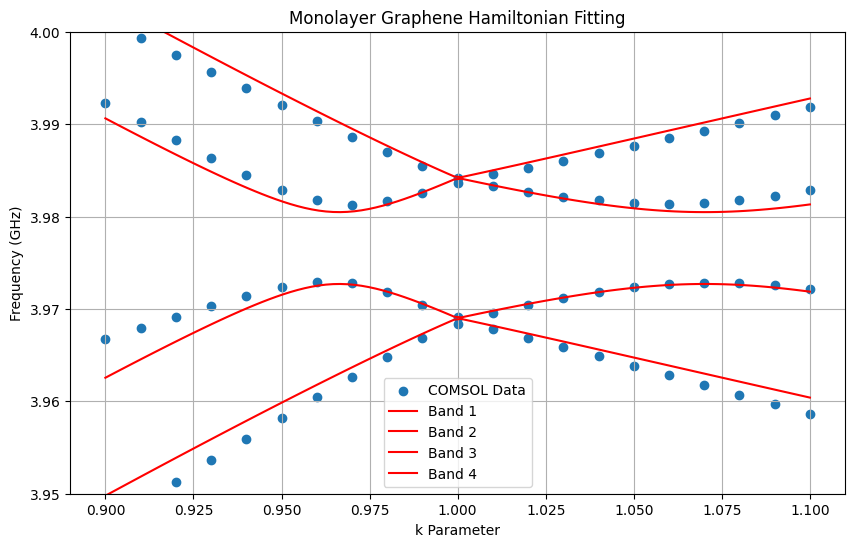

In [110]:
output_file = "h_Air20_fitted_data.txt"
gamma_0_opt, phi_opt, k_fine, fitted_freq = fit_hamiltonian('h_Air20.txt', output_file)